# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [27]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [28]:
# YOUR CODE 
df = pd.read_csv('simplified.csv')
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [29]:
from common_utils import split_dataset, preprocess_dataset

columns_to_drop = ['filename', 'label']

def preprocess(df):
    # YOUR CODE HERE
    
    # Split the dataset into training (80%) and testing (20%) sets
    # Accompanied with encoding the labels from 0 to n_classes-1 
    X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size, random_state)
    
    # Scale and prepare testing data
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

test_size = 0.2
random_state = 42

X_train, y_train, X_test, y_test = preprocess(df)

In [30]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9645, 77) (9645,)
(2412, 77) (2412,)


2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [31]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    Returns:
    X_train_scaled_dict (dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict (dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict (dict) where y_train_dict[batch_size] is a list of labels for the different folds.
    y_val_dict (dict) where y_val_dict[batch_size] is a list of labels for the different folds.
    """
    X_train_scaled_dict = {}  # Dictionary to store preprocessed training values for each Batch Size
    X_val_scaled_dict = {}    # Dictionary to store preprocessed validation for each Batch Size
    y_train_dict = {}         # Dictionary to store labels for training data for each Batch Size
    y_val_dict = {}           # Dictionary to store labels for validation data for each Batch Size
    
    for batch_size in parameters:
        X_train_folds = []  # List to store preprocessed training matrices for each fold
        X_val_folds = []    # List to store preprocessed validation matrices for each fold
        y_train_folds = []  # List to store labels for training data for each fold
        y_val_folds = []    # List to store labels for validation data for each fold
        
        # Define the number of folds for cross-validation (e.g., 5 for 5-fold CV)
        n_splits = 5
        
        # Create K-fold cross-validation splits
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        
        for train_idx, val_idx in kf.split(X_train, y_train):
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Preprocess the data for this batch size (e.g., scaling)
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)
            
            # Append preprocessed data to lists
            X_train_folds.append(X_train_fold_scaled)
            X_val_folds.append(X_val_fold_scaled)
            y_train_folds.append(y_train_fold)
            y_val_folds.append(y_val_fold)
        
        # Store the data for this batch size in the dictionaries
        X_train_scaled_dict[batch_size] = X_train_folds
        X_val_scaled_dict[batch_size] = X_val_folds
        y_train_dict[batch_size] = y_train_folds
        y_val_dict[batch_size] = y_val_folds
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

# Example usage
batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train)



3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# early stopping obtained from tutorial
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
# network (MLP defined in QA1)
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),  # Input layer to first hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(no_hidden, 128),          # First hidden layer to second hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(128, 128),                # Second hidden layer to third hidden layer
            nn.ReLU(),                          # ReLU activation
            nn.Dropout(0.2),                    # Dropout with probability 0.2

            nn.Linear(128, no_labels),          # Third hidden layer to output layer
            nn.Sigmoid()                        # Sigmoid activation for binary classification
        )

    # YOUR CODE HERE
    def forward(self, x):
        # Define the forward pass of the neural network
        return self.mlp_stack(x)

# torch datasets (CustomDataset defined in QA1)
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X) 
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return x_sample, y_sample

# loss function (loss_fn defined in QA1)
loss_fn = nn.CrossEntropyLoss()

# Initialising Dictionaries
epoch_acc_dict = {}
epoch_time_dict = {}

def training_batch(X_train, y_train, X_val, y_val, batch_size):
    
    epochs = 100
    # Place holder to hold the accuracies for the batch
    acc = []
    timings = []
    
    # Convert input data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.LongTensor(y_val)

    # Create DataLoader for training data
    train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create and initialize the model
    model = MLP(no_features=X_train.shape[1], no_hidden=128, no_labels=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Implementing Early Stopper based on Part A_1
    early_stopper = EarlyStopper(patience=3, min_delta=0)
    
    # Record Time Taken for Each Training
    start_time = time.time()
    
    for epoch in range(epochs):
        
        epoch_start = time.time()
        
        # Training loop
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Optimization
            optimizer.step()
            train_loss += loss.item()
            
        # Validation evaluation
        model.eval()
        
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = loss_fn(val_predictions, y_val_tensor)

            # Calculate accuracy on the validation fold
            predicted_labels = torch.argmax(val_predictions, dim=1)
            accuracy = torch.sum(predicted_labels == y_val_tensor).item() / len(y_val_tensor)
            acc.append(accuracy)
            

        # Early stopping check based on validation loss
        if early_stopper.early_stop(val_loss.item()):
            # Calculate time taken for one epoch cycle
            epoch_end = time.time() - epoch_start
            timings.append(epoch_end)
            print(f"Early stopping triggered at epoch {epoch + 1}")
            print(f"Time Taken for Epoch: {epoch_end} s")
            break
            
    epoch_acc_dict[batch_size] = acc
    epoch_time_dict[batch_size] = timings
    training_time = time.time() - start_time

    return accuracy, training_time

In [33]:
# YOUR CODE HERE
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter_name):
    optimal_hyperparameters = {}
    cross_validation_accuracies = []
    cross_validation_times = []

    for batch_size in batch_sizes:
        fold_accuracies = []
        fold_times = []

        for fold_idx in range(5):
            X_train_fold, y_train_fold = X_train_scaled_dict[batch_size][fold_idx], y_train_dict[batch_size][fold_idx]
            X_val_fold, y_val_fold = X_val_scaled_dict[batch_size][fold_idx], y_val_dict[batch_size][fold_idx]

            accuracy, training_time = training_batch(X_train_fold, y_train_fold, X_val_fold, y_val_fold, batch_size)
            fold_accuracies.append(accuracy)
            fold_times.append(training_time)
            
            print(f"Batch Size {batch_size}: | Fold {fold_idx+1} | Training Accuracy: {accuracy}")
            
        
        mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
        mean_time = sum(fold_times) / len(fold_times)

        #print(f"Batch Size {batch_size}: | Fold {fold_idx} | Mean Training Accuracy: {fold_accuracies}")
        print(f"Mean Training Time: {mean_time} s")
        print(f"Mean 5-Fold Cross Validation Accuracy: {mean_accuracy}")
        print("--------------------------------------------------------------------------")
        
        # Append Mean Cross Validation Accuracy 
        cross_validation_accuracies.append(mean_accuracy)
        cross_validation_times.append(mean_time)

        if hyperparameter_name not in optimal_hyperparameters:
            optimal_hyperparameters[hyperparameter_name] = []
        optimal_hyperparameters[hyperparameter_name].append(batch_size)
    
    #print(cross_validation_accuracies)
    return cross_validation_accuracies, cross_validation_times

cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

Early stopping triggered at epoch 25
Time Taken for Epoch: 0.15460920333862305 s
Batch Size 64: | Fold 1 | Training Accuracy: 0.71850699844479
Early stopping triggered at epoch 25
Time Taken for Epoch: 0.1773979663848877 s
Batch Size 64: | Fold 2 | Training Accuracy: 0.7159149818558839
Early stopping triggered at epoch 24
Time Taken for Epoch: 0.17546916007995605 s
Batch Size 64: | Fold 3 | Training Accuracy: 0.7148781752203214
Early stopping triggered at epoch 30
Time Taken for Epoch: 0.1459197998046875 s
Batch Size 64: | Fold 4 | Training Accuracy: 0.7304302747537584
Early stopping triggered at epoch 22
Time Taken for Epoch: 0.14668488502502441 s
Batch Size 64: | Fold 5 | Training Accuracy: 0.7091757387247278
Mean Training Time: 4.2207643508911135 s
Mean 5-Fold Cross Validation Accuracy: 0.7177812337998963
--------------------------------------------------------------------------
Early stopping triggered at epoch 23
Time Taken for Epoch: 0.10018110275268555 s
Batch Size 128: | Fold 1

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

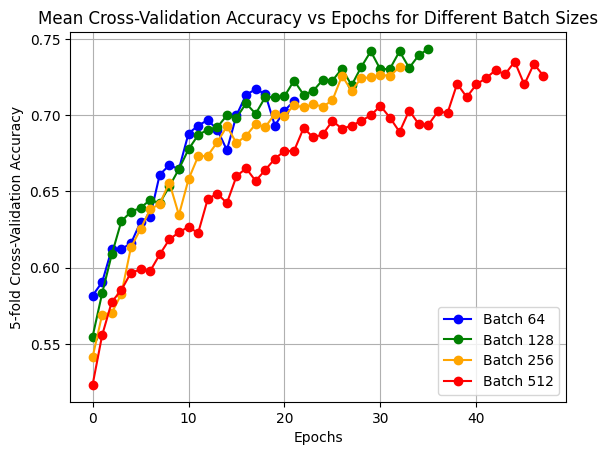

In [34]:
# Plotting cross-validation accuracy for different batch sizes with enhanced labels and colors
batch_sizes = [64, 128, 256, 512]
colors = ['blue', 'green', 'orange', 'red']
for i, batch_size in enumerate(batch_sizes):
    plt.plot(epoch_acc_dict[batch_size], label=f"Batch {batch_size}", color=colors[i], linestyle='-', marker='o')

plt.xlabel('Epochs')
plt.ylabel('5-fold Cross-Validation Accuracy')
plt.title('Mean Cross-Validation Accuracy vs Epochs for Different Batch Sizes')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
epoch_time_list = list()
for i in epoch_time_dict.values():
    epoch_time_list.append(i[0])

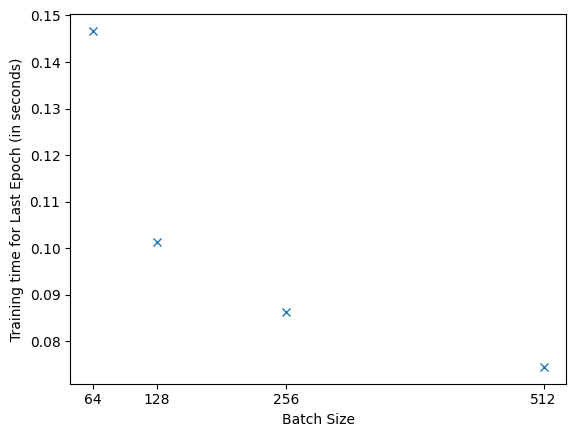

In [36]:
plt.plot(batch_sizes, epoch_time_list, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('Batch Size')
plt.ylabel('Training time for Last Epoch (in seconds)')
plt.show()

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [37]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': epoch_time_list
                  })

df

,Batch Size,Last Epoch Time
0,64,0.146685
1,128,0.101418
2,256,0.086380
3,512,0.074497


In [38]:
# YOUR CODE HERE
optimal_batch_size = 512
reason = """
        From above we can observe the running time and accuracy, we know that batch size of 512 is the optimal because it has the 
        lowest Epoch Time after 5 Folds of training"""